Individual Parameter ID Plan: Actuator and Spring modelling. 

Mohammad Zaki Patel

As a team we have decided that we will be using a rubber band spring as our energy storing mechanism. For our actuator we are planning to use a full 360 rotation servo motor and the specifications are given below. 

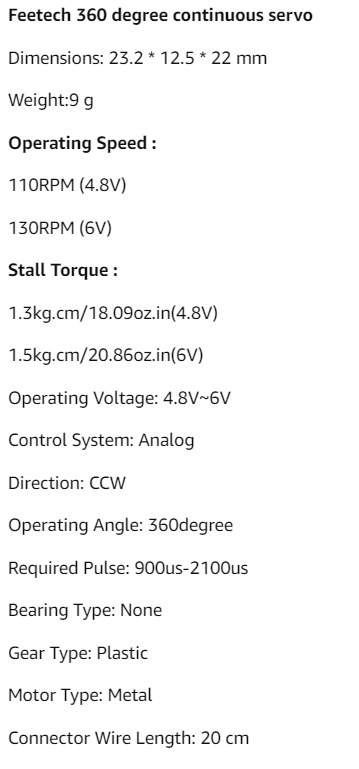

To approximate the spring and damper coefficents of the system, a basic simulation was constructed, then the constants were manually tuned to achieve the best approximation of the experimental results. The code for building and plotting the simulated system is shown below.

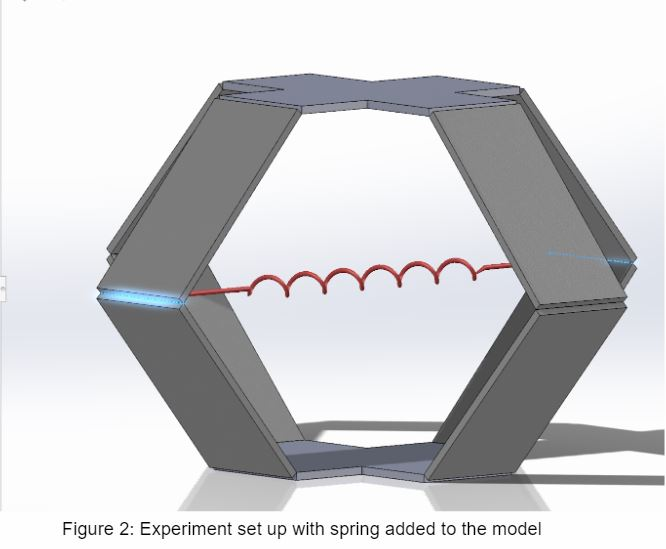

In [1]:
#!pip install pynamics 
#!pip install ffmpeg-python

In [2]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import KinematicConstraint,AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
tol = 1e-4

In [4]:
# Time parameters
tinitial = 0
tfinal = 5
fps = 120
tstep = 1/fps
t = np.r_[tinitial:tfinal:tstep]

For this model I am considering the mass of the links based on weight of the cardstock which was found out using a kitchen scale. I multiplied the weight by 2 since the manufactured model will have 2 layers of the cardstock material. All the masses are in kgs and the link length in meters.


In [5]:
# System
system = System()
pynamics.set_system(__name__,system)

# System constants
length = 0.1016
width = 0.06
mass = 0.006
g = Constant(9.81,'g',system)
b = Constant(0.0041,'b',system) 
k = Constant(0.01,'k',system) 
lA = Constant(length,'lA',system) 
mA = Constant(mass,'mA',system)

In [6]:
# Inertia
Ixx_A = Constant((1/12)*mass*(width**2), 'Ixx_A', system)
Iyy_A = Constant((1/12)*mass*(width**2 + length**2), 'Iyy_A', system)
Izz_A = Constant((1/12)*mass*(length**2),'Izz_A',system)

In [7]:
# State variables
qA,qA_d,qA_dd = Differentiable('qA',system)
state_variables = system.get_state_variables()

# Initial values for state variables
initialvalues = {}
initialvalues[qA] = -np.pi
initialvalues[qA_d] = 0
ini = [initialvalues[item] for item in state_variables]

In [8]:
# Frames
N = Frame('N',system)
A = Frame('A',system)
system.set_newtonian(N)
A.rotate_fixed_axis(N,[0,0,1],qA,system)

In [9]:
# Kinematics
pA = 0*N.x
pB = pA + lA*A.x

# Center of mass
pAcm = pA + (lA/2)*A.x

# Joint velocity
wA = N.get_w_to(A)

# Bodies
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)

In [10]:
# Forces
system.addforce(-b*wA, wA) # Damping
system.add_spring_force1(k, (qA + (np.pi/2))*N.z, wA)
system.addforcegravity(-g*N.y) # Gravity


In [11]:
# F=ma
f,ma = system.getdynamics()

# Solve for acceleration
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-04-14 06:55:18,828 - pynamics.system - INFO - getting dynamic equations
2022-04-14 06:55:18,875 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-14 06:55:18,901 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-14 06:55:19,048 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-14 06:55:19,055 - pynamics.system - INFO - calculating function for lambdas


In [12]:
# Integrate
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-04-14 06:55:19,179 - pynamics.integration - INFO - beginning integration
2022-04-14 06:55:19,186 - pynamics.system - INFO - integration at time 0000.00
2022-04-14 06:55:19,214 - pynamics.integration - INFO - finished integration


2022-04-14 06:55:19,238 - pynamics.output - INFO - calculating outputs
2022-04-14 06:55:19,255 - pynamics.output - INFO - done calculating outputs


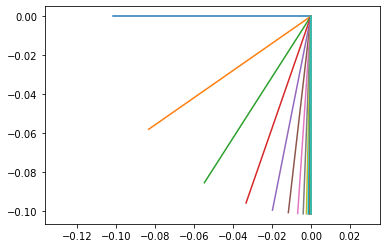

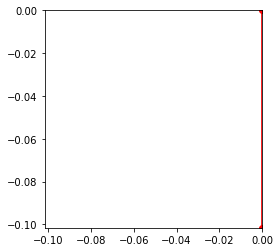

In [13]:
# Motion
points = [pA, pB]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

# Animate
points_output.animate(fps = fps,movie_name = 'render.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

HTML(points_output.anim.to_html5_video())

From this pynamics model I was able to find out the spring constant for our model. We will be using this spring constant in our System Dynamics II assignment. 
